In [1]:
##import necessary libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline


In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

data = requests.get(url).text

soup = BeautifulSoup(data, 'html5lib')

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [3]:
# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [4]:
#Let's have a look to the first 10 rows of our dataset
df.head(10)

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government
5        M9A         Etobicoke                  Islington Avenue
6        M1B       Scarborough                    Malvern, Rouge
7        M3B        North York                   Don Mills North
8        M4B         East York   Parkview Hill, Woodbine Gardens
9        M5B  Downtown Toronto          Garden District, Ryerson

In [5]:
df.shape

(103, 3)

In [6]:
#So now data is cleaned. We add Latitude and Longitudes coordinates for each location via geocoder
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

In [7]:
#we now merge the first dataframe with k

df_merged = pd.merge(df, geo_df, on='PostalCode')

In [8]:
#let's have a look to data
df_merged.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [9]:
df_merged['Borough'].unique()

array(['North York', 'Downtown Toronto', "Queen's Park", 'Etobicoke',
       'Scarborough', 'East York', 'York', 'East Toronto', 'West Toronto',
       'East York/East Toronto', 'Central Toronto', 'Mississauga',
       'Downtown Toronto Stn A', 'Etobicoke Northwest',
       'East Toronto Business'], dtype=object)

In [10]:
#let's now create a visual map o Toronto's neighborhood

# first we import the needed libraries

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
! pip install folium
import folium



/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [11]:
df= df_merged
df.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [12]:
! pip install folium
import folium

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [13]:
# let's identify the borough via different random colors

boroughs = df['Borough'].unique().tolist()

borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [14]:
map_toronto = folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill=True,
        fill_color=borough_color[borough],
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [15]:
# we try now to simplify even more the analysis focusing only on Toronto's

dtt_data = df[df['Borough'].isin(['Downtown Toronto','East Toronto', 'West Toronto',
       'East York/East Toronto', 'Central Toronto', 'Downtown Toronto Stn A',
       'East Toronto Business'])].reset_index(drop=True)
dtt_data.head()

PostalCode           Borough               Neighborhood   Latitude  \
0        M5A  Downtown Toronto  Regent Park, Harbourfront  43.654260   
1        M5B  Downtown Toronto   Garden District, Ryerson  43.657162   
2        M5C  Downtown Toronto             St. James Town  43.651494   
3        M4E      East Toronto                The Beaches  43.676357   
4        M5E  Downtown Toronto                Berczy Park  43.644771   

   Longitude  
0 -79.360636  
1 -79.378937  
2 -79.375418  
3 -79.293031  
4 -79.373306

In [16]:
map_dtt = folium.Map(location=[43.6548, -79.3883], zoom_start=11)

# add markers to map
for lat, lng, label in zip(dtt_data['Latitude'], dtt_data['Longitude'], dtt_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
         color=borough_color[borough],
        fill=True,
        fill_color=borough_color[borough],
        fill_opacity=0.7,
        parse_html=False).add_to(map_dtt)  
    
map_dtt

In [17]:
#we will now use Fourfsquare 

 #let's first retrive the credential
CLIENT_ID = '1NRGN0XLZXFGIFOX451VX4A303PO1GNNOZFL1VAIZOBOO2O0' 
CLIENT_SECRET = 'ZHZEOGNVHPVCUIAEFDMIAS5LUHK4XCQIKY1E143DMNYJNCKR' 
VERSION = '20210809'  
LIMIT= 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1NRGN0XLZXFGIFOX451VX4A303PO1GNNOZFL1VAIZOBOO2O0
CLIENT_SECRET:ZHZEOGNVHPVCUIAEFDMIAS5LUHK4XCQIKY1E143DMNYJNCKR


In [18]:
# we will now first get the first 100 venues in Lwrence Park with a radius of 500 meter

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                latitudes=df['Latitude'],
                                longitudes=df['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [20]:
toronto_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods              43.753259              -79.329656   
1         Parkwoods              43.753259              -79.329656   
2         Parkwoods              43.753259              -79.329656   
3  Victoria Village              43.725882              -79.315572   
4  Victoria Village              43.725882              -79.315572   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1                     KFC       43.754387       -79.333021   
2           Variety Store       43.751974       -79.333114   
3  Victoria Village Arena       43.723481       -79.315635   
4             Tim Hortons       43.725517       -79.313103   

         Venue Category  
0                  Park  
1  Fast Food Restaurant  
2     Food & Drink Shop  
3          Hockey Arena  
4           Coffee Shop

In [21]:
#let's find the most common type of venues by neighborhood

print(toronto_venues.shape)
toronto_venues.head()

(2145, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods              43.753259              -79.329656   
1         Parkwoods              43.753259              -79.329656   
2         Parkwoods              43.753259              -79.329656   
3  Victoria Village              43.725882              -79.315572   
4  Victoria Village              43.725882              -79.315572   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1                     KFC       43.754387       -79.333021   
2           Variety Store       43.751974       -79.333114   
3  Victoria Village Arena       43.723481       -79.315635   
4             Tim Hortons       43.725517       -79.313103   

         Venue Category  
0                  Park  
1  Fast Food Restaurant  
2     Food & Drink Shop  
3          Hockey Arena  
4           Coffee Shop

In [22]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                             
Agincourt                                                            5   
Alderwood, Long Branch                                               8   
Bathurst Manor, Wilson Heights, Downsview North                     23   
Bayview Village                                                      4   
Bedford Park, Lawrence Manor East                                   24   
...                                                                ...   
Willowdale West                                                      6   
Willowdale, Newtonbrook                                              3   
Woburn                                                               4   
Woodbine Heights                                                     6   
York Mills West                                                      3   

                                                 Neighborhood Longitude  \
Neighborhood                                                              
Agincourt                                                             5   
Alderwood, Long Branch                                                8   
Bathurst Manor, Wilson Heights, Downsview North                      23   
Bayview Village                                                       4   
Bedford Park, Lawrence Manor East                                    24   
...                                                                 ...   
Willowdale West                                                       6   
Willowdale, Newtonbrook                                               3   
Woburn                                                                4   
Woodbine Heights                                                      6   
York Mills West                                                       3   

                                                 Venue  Venue Latitude  \
Neighborhood                                                             
Agincourt                                            5               5   
Alderwood, Long Branch                               8               8   
Bathurst Manor, Wilson Heights, Downsview North     23              23   
Bayview Village                                      4               4   
Bedford Park, Lawrence Manor East                   24              24   
...                                                ...             ...   
Willowdale West                                      6               6   
Willowdale, Newtonbrook                              3               3   
Woburn                                               4               4   
Woodbine Heights                                     6               6   
York Mills West                                      3               3   

                                                 Venue Longitude  \
Neighborhood                                                       
Agincourt                                                      5   
Alderwood, Long Branch                                         8   
Bathurst Manor, Wilson Heights, Downsview North               23   
Bayview Village                                                4   
Bedford Park, Lawrence Manor East                             24   
...                                                          ...   
Willowdale West                                                6   
Willowdale, Newtonbrook                                        3   
Woburn                                                         4   
Woodbine Heights                                               6   
York Mills West                                                3   

                                                 Venue Category  
Neighborhood                                                     
Agincourt                                                     5  
Alderwood, Long Branch                                        8 

In [23]:
#how many unique cathegories do we have?

print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

print("The Venue Categories are", toronto_venues['Venue Category'].unique())

There are 274 uniques categories.
The Venue Categories are ['Park' 'Fast Food Restaurant' 'Food & Drink Shop' 'Hockey Arena'
 'Coffee Shop' 'Portuguese Restaurant' 'French Restaurant' 'Bakery'
 'Distribution Center' 'Restaurant' 'Spa' 'Gym / Fitness Center'
 'Historic Site' 'Chocolate Shop' 'Pub' 'Farmers Market'
 'Performing Arts Venue' 'Breakfast Spot' 'Dessert Shop'
 'Mexican Restaurant' 'Theater' 'Yoga Studio' 'Event Space' 'Shoe Store'
 'Café' 'Asian Restaurant' 'Art Gallery' 'Electronics Store' 'Bank'
 'Beer Store' 'Antique Shop' 'Boutique' 'Furniture / Home Store'
 'Vietnamese Restaurant' 'Clothing Store' 'Accessories Store'
 'Miscellaneous Shop' 'Italian Restaurant' 'Beer Bar' 'Sushi Restaurant'
 'Creperie' 'Fried Chicken Joint' 'Hobby Shop' 'Burrito Place' 'Diner'
 'Japanese Restaurant' 'Smoothie Shop' 'Sandwich Place' 'Gym'
 'College Auditorium' 'Bar' 'General Entertainment' 'Print Shop'
 'Caribbean Restaurant' 'Gastropub' 'Pharmacy' 'Pizza Place' 'Pet Store'
 'Intersection' 

In [24]:
# Do we have Italian Restaurants? SI!


"Italian Restaurant" in toronto_venues['Venue Category'].unique()



True

In [25]:
#Let's focus now on singol neighbourgh

toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped



Neighborhood  Accessories Store  \
0                                         Agincourt                0.0   
1                            Alderwood, Long Branch                0.0   
2   Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                   Bayview Village                0.0   
4                 Bedford Park, Lawrence Manor East                0.0   
..                                              ...                ...   
95                                  Willowdale West                0.0   
96                          Willowdale, Newtonbrook                0.0   
97                                           Woburn                0.0   
98                                 Woodbine Heights                0.0   
99                                  York Mills West                0.0   

    Airport  Airport Food Court  Airport Gate  Airport Lounge  \
0       0.0                 0.0           0.0             0.0   
1       0.0                 0.0           0.0             0.0   
2       0.0                 0.0           0.0             0.0   
3       0.0                 0.0           0.0             0.0   
4       0.0                 0.0           0.0             0.0   
..      ...                 ...           ...             ...   
95      0.0                 0.0           0.0             0.0   
96      0.0                 0.0           0.0             0.0   
97      0.0                 0.0           0.0             0.0   
98      0.0                 0.0           0.0             0.0   
99      0.0                 0.0           0.0             0.0   

    Airport Service  Airport Terminal  American Restaurant  Antique Shop  ...  \
0               0.0               0.0             0.000000           0.0  ...   
1               0.0               0.0             0.000000           0.0  ...   
2               0.0               0.0             0.000000           0.0  ...   
3               0.0               0.0             0.000000           0.0  ...   
4               0.0               0.0             0.041667           0.0  ...   
..              ...               ...                  ...           ...  ...   
95              0.0               0.0             0.000000           0.0  ...   
96              0.0               0.0             0.000000           0.0  ...   
97              0.0               0.0             0.000000           0.0  ...   
98              0.0               0.0             0.000000           0.0  ...   
99              0.0               0.0             0.000000           0.0  ...   

    Train Station  Truck Stop  Vegetarian / Vegan Restaurant  \
0             0.0         0.0                            0.0   
1             0.0         0.0                            0.0   
2             0.0         0.0                            0.0   
3             0.0         0.0                            0.0   
4             0.0         0.0                            0.0   
..            ...         ...                            ...   
95            0.0         0.0                            0.0   
96            0.0         0.0                            0.0   
97            0.0         0.0                            0.0   
98            0.0         0.0                            0.0   
99            0.0         0.0                            0.0   

    Video Game Store  Vietnamese Restaurant  Warehouse Store  Wine Bar  \
0                0.0                    0.0              0.0       0.0   
1                0.0                    0.0              0.0       0.0   
2                0.0                    0.0              0.0       0.0   
3                0.0                    0.0              0.0       0.0   
4                0.0                    0.0              0.0       0.0   
..               ...                    ...              ...       ...   
95               0.0                    0.0              0.0       0.0   
96               0.0               

In [26]:
#hogh level overview of venues

num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0             Breakfast Spot   0.2
1                     Lounge   0.2
2               Skating Rink   0.2
3  Latin American Restaurant   0.2
4             Clothing Store   0.2


----Alderwood, Long Branch----
         venue  freq
0  Pizza Place  0.25
1  Coffee Shop  0.12
2     Pharmacy  0.12
3          Gym  0.12
4          Pub  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
               venue  freq
0               Bank  0.09
1        Coffee Shop  0.09
2              Diner  0.04
3        Bridal Shop  0.04
4  Mobile Phone Shop  0.04


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1                 Bank  0.25
2                 Café  0.25
3   Chinese Restaurant  0.25
4    Accessories Store  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.08
1         Coffee Shop  0.08
2  Italian Restaurant  0.08
3            Pharmacy  0.04
4    Toy 

In [27]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2145, 275)


Neighborhoods  Accessories Store  Airport  Airport Food Court  \
0         Parkwoods                  0        0                   0   
1         Parkwoods                  0        0                   0   
2         Parkwoods                  0        0                   0   
3  Victoria Village                  0        0                   0   
4  Victoria Village                  0        0                   0   

   Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0             0               0                0                 0   
1             0               0                0                 0   
2             0               0                0                 0   
3             0               0                0                 0   
4             0               0                0                 0   

   American Restaurant  Antique Shop  ...  Train Station  Truck Stop  \
0                    0             0  ...              0           0   
1                    0             0  ...              0           0   
2                    0             0  ...              0           0   
3                    0             0  ...              0           0   
4                    0             0  ...              0           0   

   Vegetarian / Vegan Restaurant  Video Game Store  Vietnamese Restaurant  \
0                              0                 0                      0   
1                              0                 0                      0   
2                              0                 0                      0   
3                              0                 0                      0   
4                              0                 0                      0   

   Warehouse Store  Wine Bar  Wings Joint  Women's Store  Yoga Studio  
0                0         0            0              0            0  
1                0         0            0              0            0  
2                0         0            0              0            0  
3                0         0            0              0            0  
4                0         0            0              0            0  

[5 rows x 275 columns]

In [28]:
# group data by neighbourgh and investigate mean of frequency
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(100, 275)


Neighborhoods  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Airport  Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0      0.0                 0.0           0.0             0.0              0.0   
1      0.0                 0.0           0.0             0.0              0.0   
2      0.0                 0.0           0.0             0.0              0.0   
3      0.0                 0.0           0.0             0.0              0.0   
4      0.0                 0.0           0.0             0.0              0.0   

   Airport Terminal  American Restaurant  Antique Shop  ...  Train Station  \
0               0.0             0.000000           0.0  ...            0.0   
1               0.0             0.000000           0.0  ...            0.0   
2               0.0             0.000000           0.0  ...            0.0   
3               0.0             0.000000           0.0  ...            0.0   
4               0.0             0.041667           0.0  ...            0.0   

   Truck Stop  Vegetarian / Vegan Restaurant  Video Game Store  \
0         0.0                            0.0               0.0   
1         0.0                            0.0               0.0   
2         0.0                            0.0               0.0   
3         0.0                            0.0               0.0   
4         0.0                            0.0               0.0   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wings Joint  \
0                    0.0              0.0       0.0          0.0   
1                    0.0              0.0       0.0          0.0   
2                    0.0              0.0       0.0          0.0   
3                    0.0              0.0       0.0          0.0   
4                    0.0              0.0       0.0          0.0   

   Women's Store  Yoga Studio  
0            0.0          0.0  
1            0.0          0.0  
2            0.0          0.0  
3            0.0          0.0  
4            0.0          0.0  

[5 rows x 275 columns]

In [29]:
#focus only on those having italian restaurants

ita = to_grouped[["Neighborhoods","Italian Restaurant"]]
ita.head() 

Neighborhoods  Italian Restaurant
0                                        Agincourt            0.000000
1                           Alderwood, Long Branch            0.000000
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000
3                                  Bayview Village            0.000000
4                Bedford Park, Lawrence Manor East            0.083333

In [30]:
ita = ita.rename(columns={'Neighborhoods':'Neighborhood'})

In [31]:
# we cluster the neighbourgh. First it is important to find the k-meand via Ebow Point

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = ita.drop(['Neighborhood'], axis=1)

kmeans.fit(X)
kmeans.labels_[0:10]


array([0, 0, 0, 0, 1, 2, 0, 2, 0, 0], dtype=int32)

In [32]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

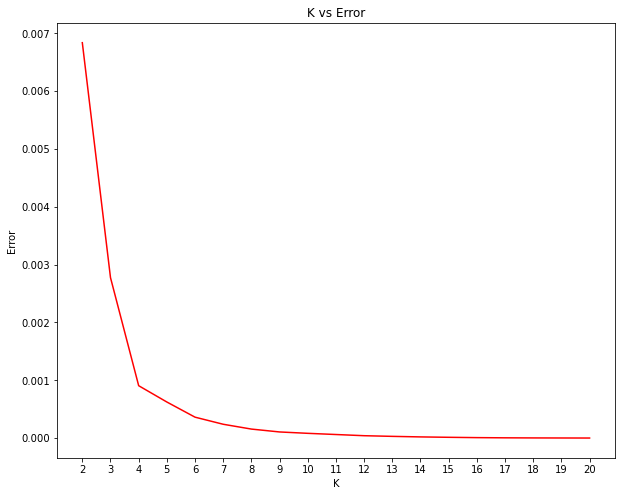

In [33]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [34]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


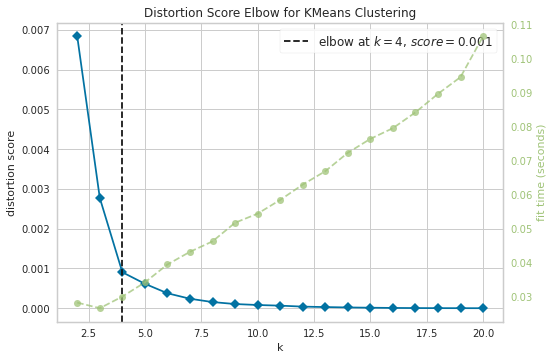

In [35]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

In [36]:
# The ptimum K value is 4 so we will have a resulting of 4 clusters

In [37]:
kclusters = 4

toronto_grouped_clustering = ita.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 2, 3, 0, 1, 0, 0], dtype=int32)

In [38]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
df_1 = ita.copy()

# add clustering labels
df_1["Cluster Labels"] = kmeans.labels_

df_1.head()

Neighborhood  Italian Restaurant  \
0                                        Agincourt            0.000000   
1                           Alderwood, Long Branch            0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000   
3                                  Bayview Village            0.000000   
4                Bedford Park, Lawrence Manor East            0.083333   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               2

In [39]:
# let's merge the dataset adding latitude/longitude for each neighborhood
df_1 = df_1.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(df_1.shape)
df_1.head()

(2145, 9)


Neighborhood  Italian Restaurant  Cluster Labels  Neighborhood Latitude  \
0    Agincourt                 0.0               0                43.7942   
0    Agincourt                 0.0               0                43.7942   
0    Agincourt                 0.0               0                43.7942   
0    Agincourt                 0.0               0                43.7942   
0    Agincourt                 0.0               0                43.7942   

   Neighborhood Longitude                        Venue  Venue Latitude  \
0              -79.262029  Panagio's Breakfast & Lunch       43.792370   
0              -79.262029                El Pulgarcito       43.792648   
0              -79.262029                     Twilight       43.791999   
0              -79.262029                       Mark's       43.791179   
0              -79.262029              Commander Arena       43.794867   

   Venue Longitude             Venue Category  
0       -79.260203             Breakfast Spot  
0       -79.259208  Latin American Restaurant  
0       -79.258584                     Lounge  
0       -79.259714             Clothing Store  
0       -79.267989               Skating Rink

In [40]:
# We sort the results by Cluster Labels
print(df_1.shape)
df_1.sort_values(["Cluster Labels"], inplace=True)
df_1

(2145, 9)


Neighborhood  Italian Restaurant  \
0                                           Agincourt            0.000000   
48          Kensington Market, Chinatown, Grange Park            0.000000   
48          Kensington Market, Chinatown, Grange Park            0.000000   
48          Kensington Market, Chinatown, Grange Park            0.000000   
48          Kensington Market, Chinatown, Grange Park            0.000000   
..                                                ...                 ...   
76                                     St. James Town            0.034884   
76                                     St. James Town            0.034884   
76                                     St. James Town            0.034884   
76                                     St. James Town            0.034884   
40  Harbourfront East, Union Station, Toronto Islands            0.020000   

    Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0                0              43.794200              -79.262029   
48               0              43.653206              -79.400049   
48               0              43.653206              -79.400049   
48               0              43.653206              -79.400049   
48               0              43.653206              -79.400049   
..             ...                    ...                     ...   
76               3              43.651494              -79.375418   
76               3              43.651494              -79.375418   
76               3              43.651494              -79.375418   
76               3              43.651494              -79.375418   
40               3              43.640816              -79.381752   

                                   Venue  Venue Latitude  Venue Longitude  \
0            Panagio's Breakfast & Lunch       43.792370       -79.260203   
48                  Bellevue Square Park       43.653610       -79.402199   
48                        Juicy Dumpling       43.652722       -79.398498   
48                          Icha Tea 一茶間       43.651336       -79.397370   
48                         Ozzy's Burger       43.655191       -79.402610   
..                                   ...             ...              ...   
76                             Sud Forno       43.650940       -79.379045   
76                            C'est What       43.648426       -79.373439   
76                               Henry's       43.652985       -79.375381   
76  St. Lawrence Market (North Building)       43.648793       -79.371945   
40                        360 Restaurant       43.642537       -79.387042   

         Venue Category  
0        Breakfast Spot  
48                 Park  
48  Dumpling Restaurant  
48             Tea Room  
48         Burger Joint  
..                  ...  
76               Bakery  
76             Beer Bar  
76           Print Shop  
76       Farmers Market  
40             Wine Bar  

[2145 rows x 9 columns]

In [41]:
#How many Italian Restaurant do we have?

df_1['Venue Category'].value_counts()['Italian Restaurant']


42

In [42]:
# There are a total of 42 locations in Toronto with Italian Restaurants in Toronto

#We will create a new dataframe with the Neighborhood and Italian Restaurants

# create map
map_clusters = folium.Map(location=[43.6548, -79.3883], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_1['Neighborhood Latitude'], df_1['Neighborhood Longitude'], df_1['Neighborhood'], df_1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters


In [43]:
#How many Neighborhoods per Cluster?
ita["Cluster Labels"] = kmeans.labels_
ita.head()

Neighborhood  Italian Restaurant  \
0                                        Agincourt            0.000000   
1                           Alderwood, Long Branch            0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000   
3                                  Bayview Village            0.000000   
4                Bedford Park, Lawrence Manor East            0.083333   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               2

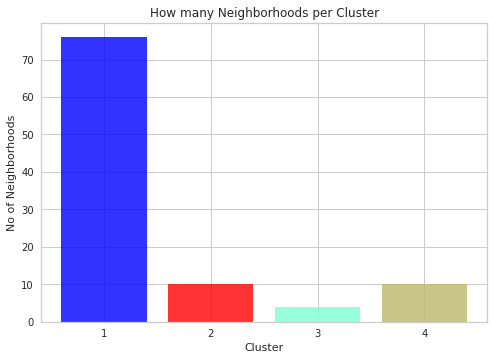

In [44]:

objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['blue', 'red','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [45]:
# How many neighborhoods in each cluster
ita['Cluster Labels'].value_counts()

0    76
3    10
1    10
2     4
Name: Cluster Labels, dtype: int64

## Analysis of each cluster



In [46]:
# We create a base dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                      Neighborhood
0        North York                         Parkwoods
1        North York                  Victoria Village
2  Downtown Toronto         Regent Park, Harbourfront
3        North York  Lawrence Manor, Lawrence Heights
4      Queen's Park     Ontario Provincial Government

In [47]:
#1 - Blue

cluster1 = df_1.loc[df_1['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1

Borough                                       Neighborhood  \
0    North York                                          Parkwoods   
1    North York                                          Parkwoods   
2    North York                                          Parkwoods   
3    North York                                   Victoria Village   
4    North York                                   Victoria Village   
..          ...                                                ...   
974   Etobicoke  Mimico NW, The Queensway West, South of Bloor,...   
975   Etobicoke  Mimico NW, The Queensway West, South of Bloor,...   
976   Etobicoke  Mimico NW, The Queensway West, South of Bloor,...   
977   Etobicoke  Mimico NW, The Queensway West, South of Bloor,...   
978   Etobicoke  Mimico NW, The Queensway West, South of Bloor,...   

     Italian Restaurant  Cluster Labels  Neighborhood Latitude  \
0                   0.0               0              43.753259   
1                   0.0               0              43.753259   
2                   0.0               0              43.753259   
3                   0.0               0              43.725882   
4                   0.0               0              43.725882   
..                  ...             ...                    ...   
974                 0.0               0              43.628841   
975                 0.0               0              43.628841   
976                 0.0               0              43.628841   
977                 0.0               0              43.628841   
978                 0.0               0              43.628841   

     Neighborhood Longitude                                  Venue  \
0                -79.329656                          Variety Store   
1                -79.329656                                    KFC   
2                -79.329656                        Brookbanks Park   
3                -79.315572                            Tim Hortons   
4                -79.315572                 Victoria Village Arena   
..                      ...                                    ...   
974              -79.520999                                 Subway   
975              -79.520999                   Kingsway Boxing Club   
976              -79.520999  Koala Tan Tanning Salon & Sunless Spa   
977              -79.520999             Royal Canadian Legion #210   
978              -79.520999                Jim & Maria's No Frills   

     Venue Latitude  Venue Longitude        Venue Category  
0         43.751974       -79.333114     Food & Drink Shop  
1         43.754387       -79.333021  Fast Food Restaurant  
2         43.751976       -79.332140                  Park  
3         43.725517       -79.313103           Coffee Shop  
4         43.723481       -79.315635          Hockey Arena  
..              ...              ...                   ...  
974       43.631659       -79.519001        Sandwich Place  
975       43.627254       -79.526684                   Gym  
976       43.631370       -79.519006         Tanning Salon  
977       43.628855       -79.518903           Social Club  
978       43.631152       -79.518617         Grocery Store  

[979 rows x 10 columns]

In [48]:
df_cluster1.sort_values(["Italian Restaurant"], ascending=False)

Borough                                       Neighborhood  \
832  Downtown Toronto             First Canadian Place, Underground city   
845  Downtown Toronto             First Canadian Place, Underground city   
865  Downtown Toronto             First Canadian Place, Underground city   
864  Downtown Toronto             First Canadian Place, Underground city   
863  Downtown Toronto             First Canadian Place, Underground city   
..                ...                                                ...   
330       Scarborough                                Scarborough Village   
331       Scarborough                                Scarborough Village   
332        North York                       Fairview, Henry Farm, Oriole   
333        North York                       Fairview, Henry Farm, Oriole   
978         Etobicoke  Mimico NW, The Queensway West, South of Bloor,...   

     Italian Restaurant  Cluster Labels  Neighborhood Latitude  \
832                0.01               0              43.648429   
845                0.01               0              43.648429   
865                0.01               0              43.648429   
864                0.01               0              43.648429   
863                0.01               0              43.648429   
..                  ...             ...                    ...   
330                0.00               0              43.744734   
331                0.00               0              43.744734   
332                0.00               0              43.778517   
333                0.00               0              43.778517   
978                0.00               0              43.628841   

     Neighborhood Longitude                                      Venue  \
832              -79.382280  Hockey Hall Of Fame (Hockey Hall of Fame)   
845              -79.382280                                 Sweet Lulu   
865              -79.382280                    Royal Alexandra Theatre   
864              -79.382280                                 Beerbistro   
863              -79.382280                     Nathan Phillips Square   
..                      ...                                        ...   
330              -79.239476                                 Tumbe Cafe   
331              -79.239476                               McCowan Park   
332              -79.346556                          Michel's Baguette   
333              -79.346556                                Oriole Park   
978              -79.520999                    Jim & Maria's No Frills   

     Venue Latitude  Venue Longitude    Venue Category  
832       43.646974       -79.377323            Museum  
845       43.650557       -79.381175  Asian Restaurant  
865       43.647255       -79.387530           Theater  
864       43.649419       -79.377237         Gastropub  
863       43.652270       -79.383516             Plaza  
..              ...              ...               ...  
330       43.744058       -79.244021     Grocery Store  
331       43.745089       -79.239336        Playground  
332       43.774326       -79.346685            Bakery  
333       43.780817       -79.351327    Baseball Field  
978       43.631152       -79.518617     Grocery Store  

[979 rows x 10 columns]

In [49]:
df_cluster1['Venue Category'].value_counts(ascending=False)['Italian Restaurant']

1

In [50]:
#2 - Red 
 
cluster2 = df_1.loc[df_1['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2

Borough                 Neighborhood  Italian Restaurant  \
0          North York              Don Mills South            0.052632   
1          North York              Don Mills South            0.052632   
2          North York              Don Mills South            0.052632   
3          North York              Don Mills South            0.052632   
4          North York              Don Mills South            0.052632   
..                ...                          ...                 ...   
404  Downtown Toronto  St. James Town, Cabbagetown            0.046512   
405  Downtown Toronto  St. James Town, Cabbagetown            0.046512   
406  Downtown Toronto  St. James Town, Cabbagetown            0.046512   
407  Downtown Toronto  St. James Town, Cabbagetown            0.046512   
408  Downtown Toronto  St. James Town, Cabbagetown            0.046512   

     Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0                 1              43.725900              -79.340923   
1                 1              43.725900              -79.340923   
2                 1              43.725900              -79.340923   
3                 1              43.725900              -79.340923   
4                 1              43.725900              -79.340923   
..              ...                    ...                     ...   
404               1              43.667967              -79.367675   
405               1              43.667967              -79.367675   
406               1              43.667967              -79.367675   
407               1              43.667967              -79.367675   
408               1              43.667967              -79.367675   

                                   Venue  Venue Latitude  Venue Longitude  \
0                     Sorento Restaurant       43.726575       -79.341989   
1                        C&C Supermarket       43.725556       -79.341667   
2                     Fitness Connection       43.727473       -79.341707   
3                                 Oomomo       43.726429       -79.343283   
4                      Tilley Endurables       43.727033       -79.342926   
..                                   ...             ...              ...   
404              Cabbagetown Boxing Club       43.666356       -79.369362   
405                     Matt's No Frills       43.663515       -79.367166   
406                   Shoppers Drug Mart       43.663998       -79.367830   
407                Cabbage Town Organics       43.664704       -79.368115   
408  Staij & Co Café and Pastry Boutique       43.666863       -79.369228   

           Venue Category  
0      Italian Restaurant  
1           Grocery Store  
2                     Gym  
3          Discount Store  
4          Clothing Store  
..                    ...  
404  Gym / Fitness Center  
405         Grocery Store  
406              Pharmacy  
407          Gourmet Shop  
408                  Café  

[409 rows x 10 columns]

In [51]:
df_cluster2.sort_values(["Italian Restaurant"], ascending=False)

Borough                   Neighborhood  Italian Restaurant  \
245  West Toronto             Runnymede, Swansea            0.058824   
243  West Toronto             Runnymede, Swansea            0.058824   
251  West Toronto             Runnymede, Swansea            0.058824   
249  West Toronto             Runnymede, Swansea            0.058824   
248  West Toronto             Runnymede, Swansea            0.058824   
..            ...                            ...                 ...   
178  West Toronto  High Park, The Junction South            0.040000   
176  West Toronto  High Park, The Junction South            0.040000   
175  West Toronto  High Park, The Junction South            0.040000   
174  West Toronto  High Park, The Junction South            0.040000   
177  West Toronto  High Park, The Junction South            0.040000   

     Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
245               1              43.651571              -79.484450   
243               1              43.651571              -79.484450   
251               1              43.651571              -79.484450   
249               1              43.651571              -79.484450   
248               1              43.651571              -79.484450   
..              ...                    ...                     ...   
178               1              43.661608              -79.464763   
176               1              43.661608              -79.464763   
175               1              43.661608              -79.464763   
174               1              43.661608              -79.464763   
177               1              43.661608              -79.464763   

                             Venue  Venue Latitude  Venue Longitude  \
245               Bloom Restaurant       43.650307       -79.479836   
243      Amber European Restaurant       43.649946       -79.482009   
251                 RBC Royal Bank       43.650142       -79.480274   
249                         Subway       43.649644       -79.484008   
248                   A Dark Horse       43.649533       -79.483056   
..                             ...             ...              ...   
178                            A&W       43.665520       -79.464731   
176  Chica’s Nashville Hot Chicken       43.665295       -79.464888   
175                      Dollarama       43.665792       -79.465906   
174                           Silk       43.665291       -79.466238   
177     Pascal's Baguette & Bagels       43.665426       -79.466176   

                Venue Category  
245  Latin American Restaurant  
243          French Restaurant  
251                       Bank  
249             Sandwich Place  
248                        Bar  
..                         ...  
178       Fast Food Restaurant  
176        Fried Chicken Joint  
175             Discount Store  
174            Thai Restaurant  
177                     Bakery  

[409 rows x 10 columns]

In [52]:
df_cluster2['Venue Category'].value_counts(ascending=False)['Italian Restaurant']

19

In [53]:
#3 - LightBlue

cluster3 = df_1.loc[df_1['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3

Borough                             Neighborhood  \
0   Downtown Toronto                                 Christie   
1   Downtown Toronto                                 Christie   
2   Downtown Toronto                                 Christie   
3   Downtown Toronto                                 Christie   
4   Downtown Toronto                                 Christie   
..               ...                                      ...   
61       Scarborough  Clarks Corners, Tam O'Shanter, Sullivan   
62       Scarborough  Clarks Corners, Tam O'Shanter, Sullivan   
63       Scarborough  Clarks Corners, Tam O'Shanter, Sullivan   
64       Scarborough  Clarks Corners, Tam O'Shanter, Sullivan   
65       Scarborough  Clarks Corners, Tam O'Shanter, Sullivan   

    Italian Restaurant  Cluster Labels  Neighborhood Latitude  \
0             0.066667               2              43.669542   
1             0.066667               2              43.669542   
2             0.066667               2              43.669542   
3             0.066667               2              43.669542   
4             0.066667               2              43.669542   
..                 ...             ...                    ...   
61            0.076923               2              43.781638   
62            0.076923               2              43.781638   
63            0.076923               2              43.781638   
64            0.076923               2              43.781638   
65            0.076923               2              43.781638   

    Neighborhood Longitude                               Venue  \
0               -79.422564                         Contra Cafe   
1               -79.422564                      Vinny’s Panini   
2               -79.422564                Scout and Cash Caffe   
3               -79.422564                           Starbucks   
4               -79.422564                          Actinolite   
..                     ...                                 ...   
61              -79.304302                            Kub Khao   
62              -79.304302                       Eight Noodles   
63              -79.304302  The Royal Chinese Restaurant 避風塘小炒   
64              -79.304302              Remezzo Italian Bistro   
65              -79.304302                         Gusto Pizza   

    Venue Latitude  Venue Longitude      Venue Category  
0        43.669107       -79.426105                Café  
1        43.670679       -79.426148  Italian Restaurant  
2        43.667360       -79.419938                Café  
3        43.671530       -79.421400         Coffee Shop  
4        43.667858       -79.428054          Restaurant  
..             ...              ...                 ...  
61       43.780438       -79.299837     Thai Restaurant  
62       43.778234       -79.308299        Noodle House  
63       43.780505       -79.298844  Chinese Restaurant  
64       43.778649       -79.308264  Italian Restaurant  
65       43.783607       -79.298983         Pizza Place  

[66 rows x 10 columns]

In [54]:
df_cluster3.sort_values(["Italian Restaurant"], ascending=False)

Borough                       Neighborhood  Italian Restaurant  \
33        North York  Bedford Park, Lawrence Manor East            0.083333   
36        North York  Bedford Park, Lawrence Manor East            0.083333   
20        North York  Bedford Park, Lawrence Manor East            0.083333   
21        North York  Bedford Park, Lawrence Manor East            0.083333   
22        North York  Bedford Park, Lawrence Manor East            0.083333   
..               ...                                ...                 ...   
11  Downtown Toronto                           Christie            0.066667   
12  Downtown Toronto                           Christie            0.066667   
13  Downtown Toronto                           Christie            0.066667   
14  Downtown Toronto                           Christie            0.066667   
0   Downtown Toronto                           Christie            0.066667   

    Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
33               2              43.733283              -79.419750   
36               2              43.733283              -79.419750   
20               2              43.733283              -79.419750   
21               2              43.733283              -79.419750   
22               2              43.733283              -79.419750   
..             ...                    ...                     ...   
11               2              43.669542              -79.422564   
12               2              43.669542              -79.422564   
13               2              43.669542              -79.422564   
14               2              43.669542              -79.422564   
0                2              43.669542              -79.422564   

                   Venue  Venue Latitude  Venue Longitude       Venue Category  
33           Francobollo       43.734557       -79.419549   Italian Restaurant  
36           Tim Hortons       43.735356       -79.419605          Coffee Shop  
20  Safari Bar and Grill       43.729051       -79.418109  American Restaurant  
21     Bruno's Fine Food       43.736642       -79.419870              Butcher  
22    Aroma Espresso Bar       43.735975       -79.420391                 Café  
..                   ...             ...              ...                  ...  
11     Marian Engel Park       43.673754       -79.423988                 Park  
12   Garrison Creek Park       43.671690       -79.427805                 Park  
13          Foto Grocery       43.667979       -79.428217        Grocery Store  
14               Loblaws       43.671657       -79.421364        Grocery Store  
0            Contra Cafe       43.669107       -79.426105                 Café  

[66 rows x 10 columns]

In [55]:
df_cluster3['Venue Category'].value_counts(ascending=False)['Italian Restaurant']

5

In [56]:
#4 - Yellow

cluster4 = df_1.loc[df_1['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4

Borough                    Neighborhood  Italian Restaurant  \
0        Queen's Park   Ontario Provincial Government            0.030303   
1        Queen's Park   Ontario Provincial Government            0.030303   
2        Queen's Park   Ontario Provincial Government            0.030303   
3        Queen's Park   Ontario Provincial Government            0.030303   
4        Queen's Park   Ontario Provincial Government            0.030303   
..                ...                             ...                 ...   
686  Downtown Toronto  University of Toronto, Harbord            0.029412   
687  Downtown Toronto  University of Toronto, Harbord            0.029412   
688  Downtown Toronto  University of Toronto, Harbord            0.029412   
689  Downtown Toronto  University of Toronto, Harbord            0.029412   
690  Downtown Toronto  University of Toronto, Harbord            0.029412   

     Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0                 3              43.662301              -79.389494   
1                 3              43.662301              -79.389494   
2                 3              43.662301              -79.389494   
3                 3              43.662301              -79.389494   
4                 3              43.662301              -79.389494   
..              ...                    ...                     ...   
686               3              43.662696              -79.400049   
687               3              43.662696              -79.400049   
688               3              43.662696              -79.400049   
689               3              43.662696              -79.400049   
690               3              43.662696              -79.400049   

                         Venue  Venue Latitude  Venue Longitude  \
0    Flock Rotisserie + Greens       43.659167       -79.389475   
1                    Starbucks       43.659456       -79.390411   
2           The Yoga Sanctuary       43.661499       -79.383636   
3                T-Swirl Crepe       43.663452       -79.384125   
4                 Central YMCA       43.663083       -79.385025   
..                         ...             ...              ...   
686  FLOCK Rotisserie + Greens       43.662637       -79.403798   
687         Hart House Theatre       43.663571       -79.394616   
688       Coach House Printing       43.666320       -79.400277   
689                 Akai Sushi       43.662470       -79.404946   
690              The Clubhouse       43.658246       -79.399894   

              Venue Category  
0        Fried Chicken Joint  
1                Coffee Shop  
2                Yoga Studio  
3                   Creperie  
4        Distribution Center  
..                       ...  
686  Comfort Food Restaurant  
687                  Theater  
688                Bookstore  
689         Sushi Restaurant  
690           Sandwich Place  

[691 rows x 10 columns]

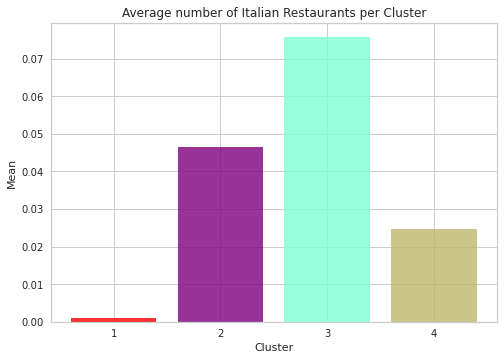

In [57]:
clusters_mean = [df_cluster1['Italian Restaurant'].mean(),df_cluster2['Italian Restaurant'].mean(),df_cluster3['Italian Restaurant'].mean(),
                 df_cluster4['Italian Restaurant'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Italian Restaurants per Cluster')

plt.show()

## Observations

Most of italia restaurants are located in cluster 3 coloured as light blue. part of this cluster are  neighborhoods of Bedford Park and Lawrence Manor East which have the highest average of italian restaurants per neighborhood.

On the contrary, even though there are the highest number (70) of neighbours in cluster 1 , coloured as Red, the average number of located italian restaurants is the lowest. 

Looking at the nearby venues, the optimum place to put a new Italian Restaurant should be Downtown Toronto as their are many Neighborhoods in the area but little to no Italian Restaurants therefore, eliminating any competition. 

Low concentration results into lower competition (more neighbours for few restaurants) and so potential investment opportunity. Having 70 neighborhoods in the area with no Italian Restaurants gives a good oppurtunity for opening up a new restaurant
